In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import IPython
import scipy.io.wavfile as wav

## ESM

$$ s(t) = \sum_k{a_k ~ e^{\delta_kt} ~ e^{i(2\pi f_k t + \phi_k)}} $$
$$ = \sum_k{\alpha_k ~ z_k^t} $$

$$ \alpha_k = a_k ~ e^{i\phi_k} $$
$$ z_k = e^{\delta_k + i2\pi f_k} $$

(63,)


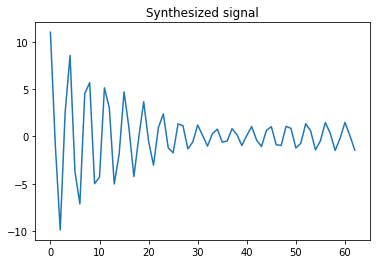

In [2]:
def synthetize(siglen, deltas, freqs, amps, phases):
    ts = np.arange(siglen).reshape(1, -1)
    pdeltas = np.minimum(deltas, 0)

    logzs = pdeltas + 1j * 2 * np.pi * freqs
    alphas = amps * np.exp(1j * phases)

    alphas = alphas.reshape(-1, 1).dot(np.ones((1, siglen)))
    zst = logzs.reshape(-1, 1).dot(ts)
    return (alphas * np.exp(zst)).T.sum(1)

siglen = 63
deltas = np.array([0, -.05])
freqs = np.array([1/4, 1/4 + 1 / siglen])
amps = np.array([1, 10])
# phases = np.random.rand(2)
phases = np.zeros(2)

synFrames = synthetize(siglen, deltas, freqs, amps, phases)
print(synFrames.shape)

plt.plot(np.real(synFrames))
plt.title("Synthesized signal")
plt.show()

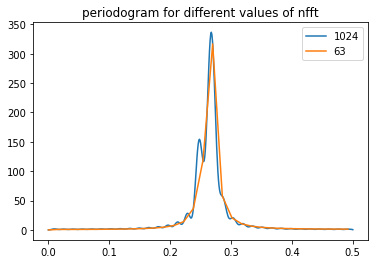

In [3]:
import scipy.signal as ss
f, ps = ss.periodogram(np.real(synFrames), nfft=1024)
plt.plot(f, ps, label=1024)
f, ps = ss.periodogram(np.real(synFrames), nfft=63)
plt.plot(f, ps, label=63)
plt.title("periodogram for different values of nfft")
plt.legend()
plt.show()

---
## HR methods

In [4]:
n, k = 32, 2

In [5]:
def hankel(x):
    """ From the scipy.linalg libs """
    c = np.asarray(x).ravel()
    r = np.zeros_like(c)
    
    vals = np.concatenate((c, r[1:]))
    a, b = np.ogrid[0:len(c), 0:len(r)]

    indx = a + b
    return vals[indx]

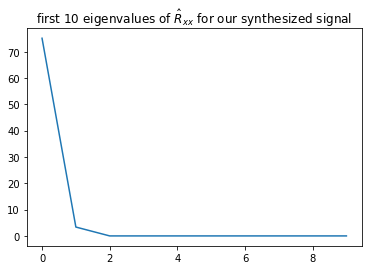

In [6]:
mX = hankel(synFrames)[:n, :(len(synFrames) - n + 1)]

mERxx = 1 / 126 * mX.dot(mX.T.conj())
u, s, v = np.linalg.svd(mERxx, full_matrices=True)

plt.plot(s[:10])
plt.title("first 10 eigenvalues of $\hat R_{xx} $ for our synthesized signal")
plt.show()

---
### ESPRIT method

In [7]:
def pinv(m):
    mH = m.T.conj()
    return np.linalg.inv(mH.dot(m)).dot(mH)

mW = u[:, :k]
mWorth = u[:, k:]
mWup = mW[1:, :]
mWdn = mW[:-1, :]

mWdnInv = pinv(mWdn)
mPhi = mWdnInv.dot(mWup)

In [8]:
s = np.linalg.eigvals(mPhi)  # linalg.svd return real values
s = sorted(s, key=lambda x: np.abs(x), reverse=True)
recDeltas = np.log(np.absolute(s))
recFreqs = np.angle(s) / 2 / np.pi
poles = np.exp(deltas + 1j * 2 * np.pi * freqs)

In [9]:
mV = np.vander(poles, siglen, increasing=True).T

def lsquares(signal, deltas, freqs):
    alphas = pinv(mV).dot(signal)
    amps = np.absolute(alphas)
    phis = np.angle(alphas)
    return amps, phis

[ 1. 10.] [ 1 10]
[-1.81105131e-15  4.71844785e-17] [0. 0.]
[-1.11022302e-16 -5.00000000e-02] [ 0.   -0.05]
[0.25       0.26587302] [0.25       0.26587302]


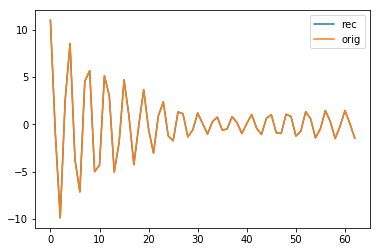

In [10]:
recAmps, recPhases = lsquares(synFrames, deltas, freqs)
recSynFrames = synthetize(siglen, recDeltas, recFreqs, recAmps, recPhases)

print(recAmps, amps)
print(recPhases, phases)
print(recDeltas, deltas)
print(recFreqs, freqs)

plt.plot(np.real(recSynFrames), label="rec")
plt.plot(np.real(synFrames), label="orig")
plt.legend()
plt.show()

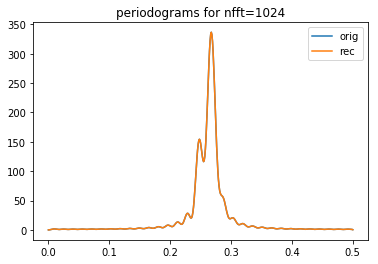

In [11]:
f, ps = ss.periodogram(np.real(synFrames), nfft=1024)
plt.plot(f, ps, label="orig")
f, ps = ss.periodogram(np.real(recSynFrames), nfft=1024)
plt.plot(f, ps, label="rec")
plt.title("periodograms for nfft=1024")
plt.legend()
plt.show()

---
### MUSIC method

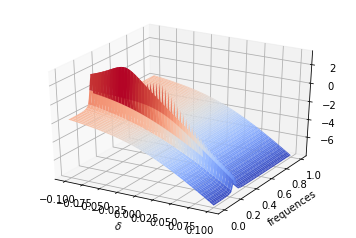

In [15]:
def music(signal, n, k):
    freqs = np.linspace(0, 1, 100)
    deltas = np.linspace(-.1, .1, 100)

    dd, ff = np.meshgrid(deltas, freqs)
#     zs = np.exp(deltas + 1j * 2 * np.pi * freqs)
    zz = np.exp(dd + 1j * 2 * np.pi * ff)

    vnz = np.array([np.vander(zs, 32, increasing=True).T for zs in zz])

    pseudospectr = 1 / (np.abs((mWorth.T.conj().dot(vnz))) ** 2).sum(0)
    return dd, ff, np.log(pseudospectr)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("$\delta$")
ax.set_ylabel("frequences")
ax.plot_surface(*music(synFrames, n, k), cmap="coolwarm")
plt.show()

8000 (95997,)


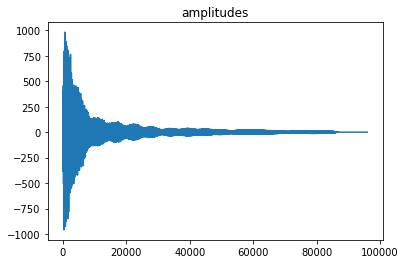

In [16]:
fn = "ClocheA.WAV"
rate, frames = wav.read(fn)
print(rate, frames.shape)

plt.plot(np.arange(len(frames)), frames)
plt.title("amplitudes")
plt.show()
IPython.display.Audio(frames, rate=rate)

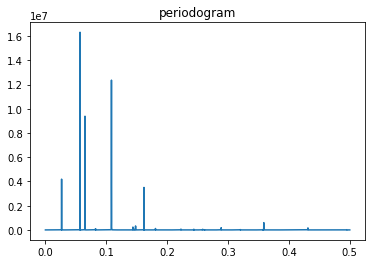

In [25]:
plt.plot(*ss.periodogram(frames))
plt.title("periodogram")
plt.show()

In [26]:
n, k, l = 512, 54, 1024